In [ ]:
# Obtaining credit card fraud detection dataset
!curl -o card_transdata.csv https://raw.githubusercontent.com/marhcouto/fraud-detection/master/data/card_transdata.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 72.7M  100 72.7M    0     0  29.0M      0  0:00:02  0:00:02 --:--:-- 29.0M


In [ ]:
# All the imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['font.size'] = 10

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mae
from tensorflow.keras.metrics import Mean
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
df = pd.read_csv('card_transdata.csv')
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [4]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Check for missing values
any(df.isna().sum() > 0)

False

In [ ]:
# Obtain categorical and numbered features
category_feats = [x for x in df.columns if len(df[x].unique()) <=2]
numbering_feats = [x for x in df.columns if x not in category_feats]

In [7]:
df['fraud'].value_counts()

,count
fraud,
0.0,912597
1.0,87403


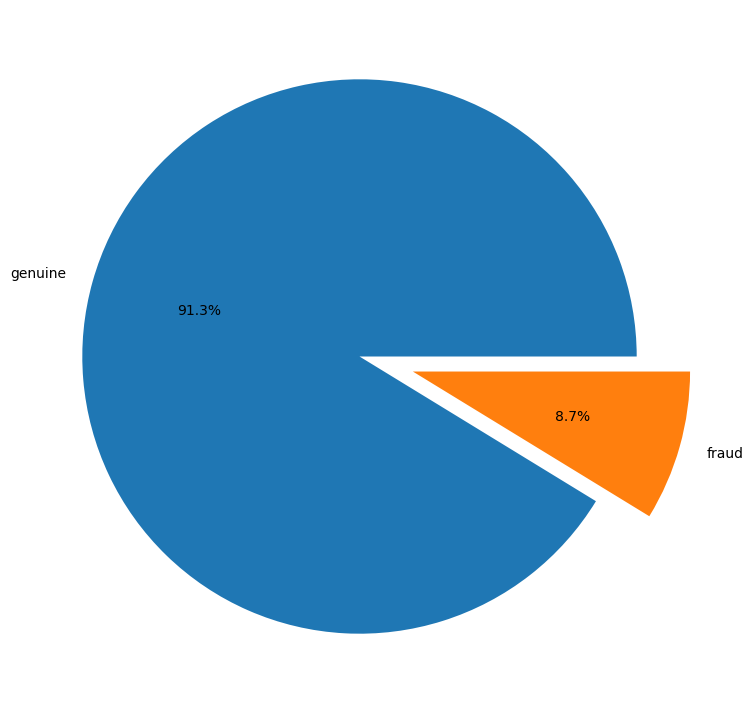

In [ ]:
# Check percentage of minority result
vc = df['fraud'].value_counts(ascending=False)

plt.pie(x=vc.values, labels=['genuine','fraud'], explode=[0.0, 0.2], autopct='%1.1f%%')
plt.show()

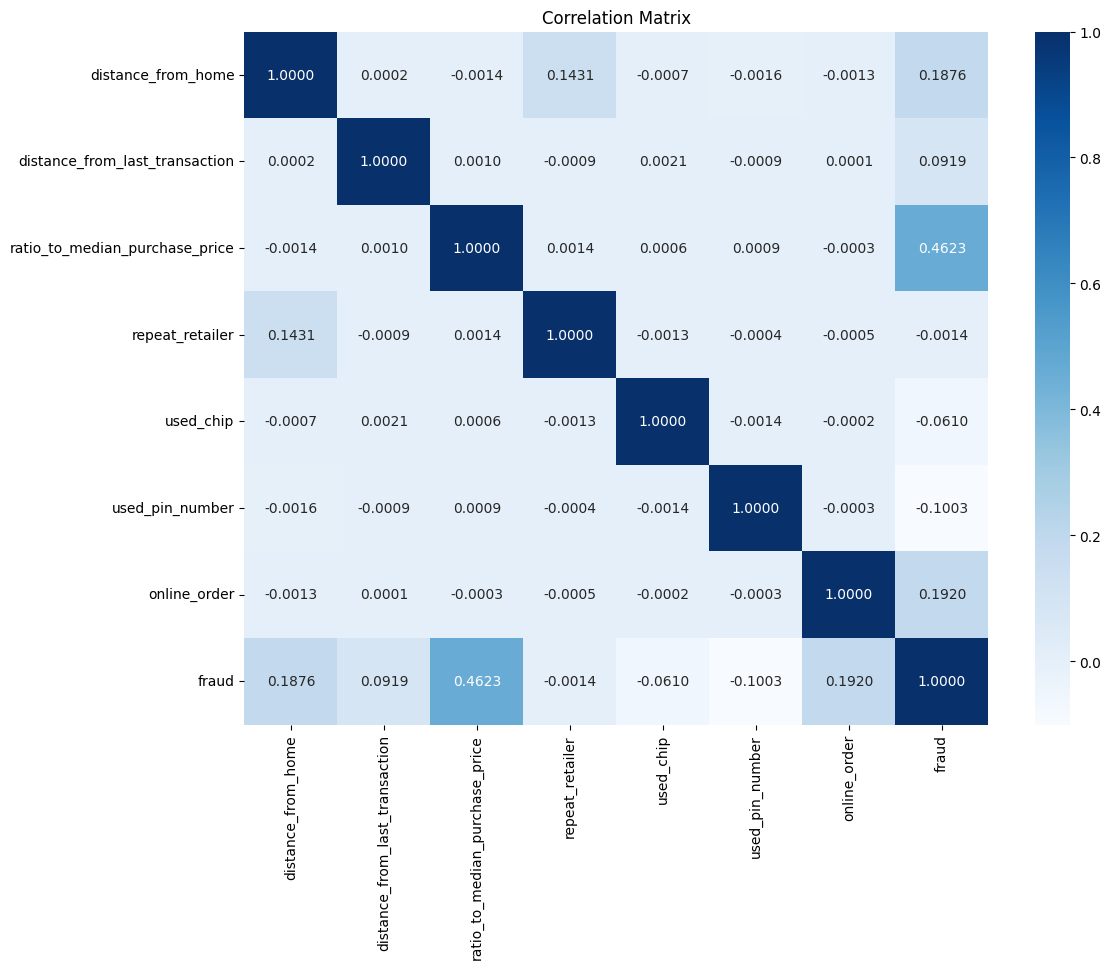

In [ ]:
# Obtain correlation matrix
sns.heatmap(df.corr(), annot=True, fmt='.4f', cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

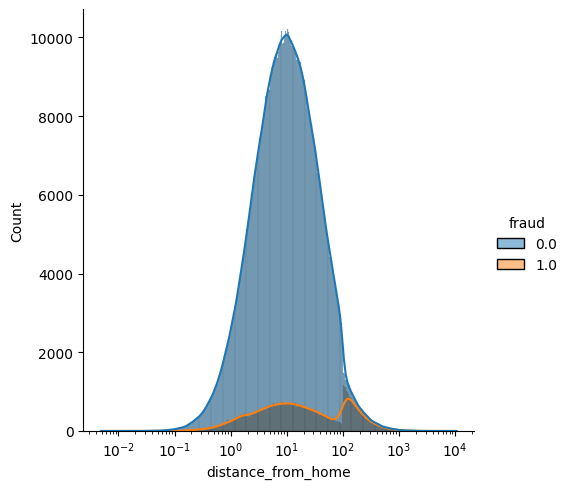

In [ ]:
# Feature data distribution
sns.displot(data=df, x='distance_from_home', hue='fraud', log_scale=True, kde=True)
plt.show()

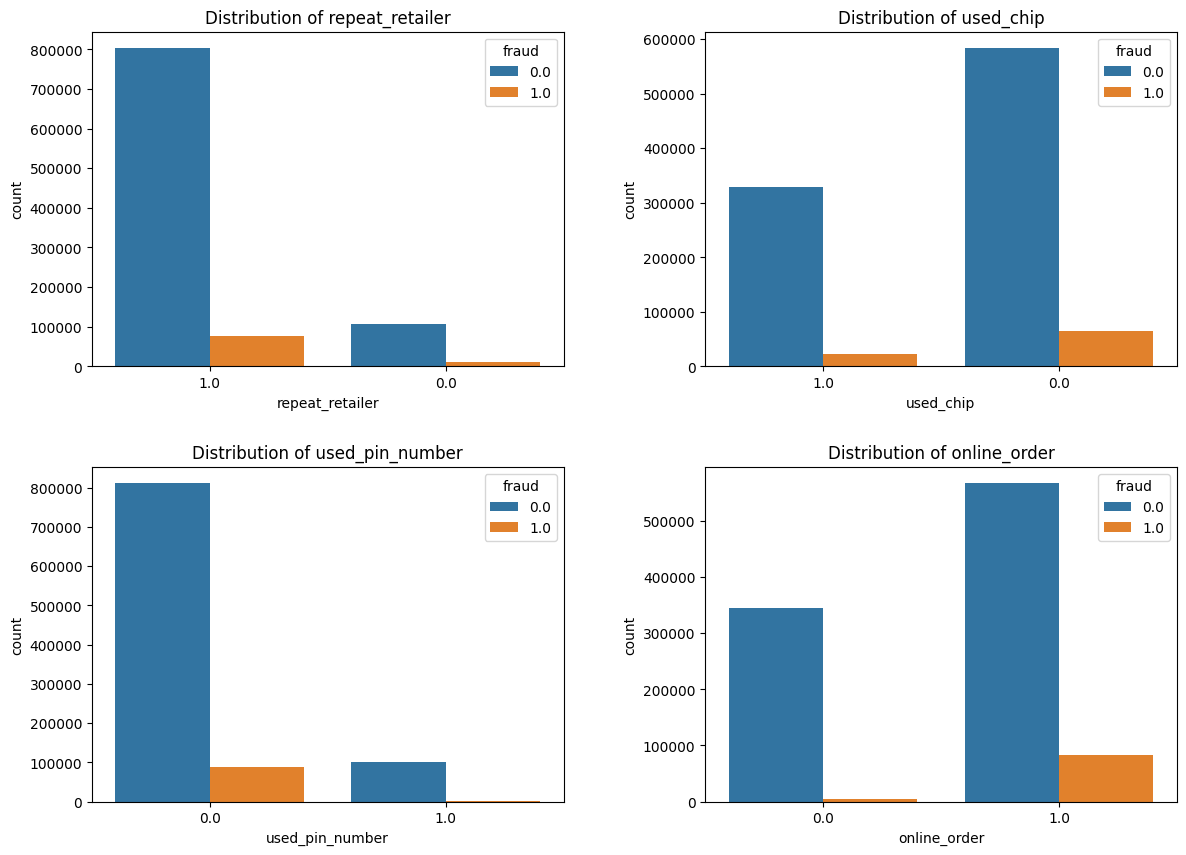

In [11]:
feats_to_plot = df.columns[3:-1]
plt.figure(figsize=(14,10))
for i, col in enumerate(feats_to_plot):
    plt.subplot(2,2,i+1)
    sns.countplot(x=df[col].astype(str), hue=df['fraud'])
    plt.title(f'Distribution of {col}')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

In [ ]:
# Scaling data between -1 and 1
ct = make_column_transformer(
    (StandardScaler(), numbering_feats)
)

df_scaled = pd.DataFrame(ct.fit_transform(df), columns=numbering_feats)
df_cat_feats = df[category_feats]

df_concat = pd.concat([df_scaled, df_cat_feats], axis=1)
df_concat.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,0.477882,-0.182849,0.043491,1.0,1.0,0.0,0.0,0.0
1,-0.241607,-0.188094,-0.189300,1.0,0.0,0.0,0.0,0.0
2,-0.329369,-0.163733,-0.498812,1.0,0.0,0.0,1.0,0.0
3,-0.372854,0.021806,-0.522048,1.0,1.0,0.0,1.0,0.0
4,0.268572,-0.172968,0.142373,1.0,1.0,0.0,1.0,0.0


In [ ]:
# Prepare data for training
X = df_concat.drop(['fraud'], axis=1)
y = df_concat['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

X_train_genuine = X_train[~y_train]
X_test_genuine = X_test[~y_test]

X_train_fraud = X_train[y_train]
X_test_fraud = X_test[y_test]

In [ ]:
# Autoencoder model
CODE_DIM = 2
INPUT_SHAPE = X_train.shape[1]

input_layer = Input(shape=(INPUT_SHAPE,))
x = Dense(64, activation='relu')(input_layer)
x = Dense(16, activation='relu')(x)
code = Dense(CODE_DIM, activation='relu')(x)
x = Dense(16, activation='relu')(code)
x = Dense(64, activation='relu')(x)
output_layer = Dense(INPUT_SHAPE, activation='relu')(x)

autoencoder = Model(input_layer, output_layer, name='anomaly')

In [ ]:
# Initializing checkpoint saving and early stopping
model_name = "anomaly.weights.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            save_weights_only=True,
                            verbose=1)
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta = 0,
                              patience = 5,
                              verbose = 1,
                              restore_best_weights=True)

callbacks = [checkpoint, earlystopping]

In [ ]:

# Prepares autoencoder model to be trained using MAE loss and Adam optimizer.
autoencoder.compile(loss='mae',
                    optimizer=Adam())

In [ ]:
# Training
history = autoencoder.fit(X_train_genuine, X_train_genuine,
                          epochs=25, batch_size=64,
                          validation_data=(X_test, X_test),
                          callbacks=callbacks, shuffle=True)

Epoch 1/25
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2338
Epoch 1: val_loss improved from inf to 0.24832, saving model to anomaly.weights.h5
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - loss: 0.2338 - val_loss: 0.2483
Epoch 2/25
11405/11408 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2263
Epoch 2: val_loss improved from 0.24832 to 0.24801, saving model to anomaly.weights.h5
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - loss: 0.2263 - val_loss: 0.2480
Epoch 3/25
11400/11408 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2254
Epoch 3: val_loss did not improve from 0.24801
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.2254 - val_loss: 0.2483
Epoch 4/25
11395/11408 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2255
Epoch 4: val_loss improved from 0.24801 to 0.24733, saving model to anomaly.weights.h5
11408/11408 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 0.2255 - val_loss: 0.2473
Epoch 5/25
11397/11408 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2197
Epoch 5: val_loss imp

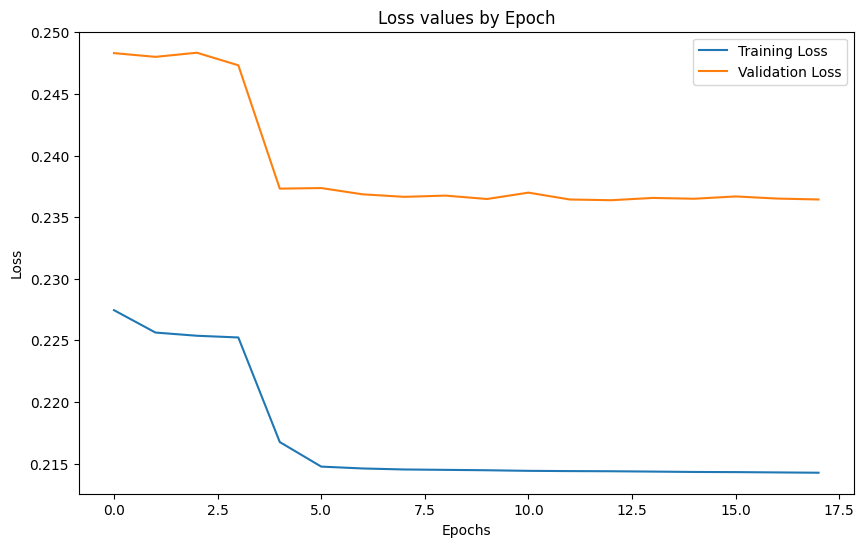

In [18]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss values by Epoch")
plt.show()

In [ ]:
# Autoencoder reconstructing the test data
reconstructions = autoencoder.predict(X_test, verbose=0)
reconstruction_error = mae(reconstructions, X_test)

In [ ]:
# Prepare a structured table that associates each test sample with reconstruction error and true label
recons_df = pd.DataFrame({
    'error': reconstruction_error,
    'y_true': y_test
}).reset_index(drop=True)
recons_df.head()

,error,y_true
0,0.115469,False
1,0.060585,False
2,0.302406,True
3,0.105787,False
4,0.291239,False


In [ ]:
# Runs the function with 10 thresholds to tune the threshold for detecting anomalies.
def thresholdTuning(df, iterations):

    thresh_df = {
        'threshold': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }

    for i in range(iterations):
        thresh_value = df['error'].quantile(i/iterations)
        preds = df['error'] > thresh_value
        cr = classification_report(df['y_true'], preds, output_dict=True)
        acc = cr['accuracy']
        prec = cr['macro avg']['precision']
        rc = cr['macro avg']['recall']

        thresh_df['threshold'].append(thresh_value)
        thresh_df['accuracy'].append(acc)
        thresh_df['precision'].append(prec)
        thresh_df['recall'].append(rc)

        print(f"Threshold: {thresh_value:.4f}\tAccuracy: {acc:.3f}\t\tPrecision: {prec:.3f}\tRecall Score: {rc:.3f}")

    return pd.DataFrame(thresh_df)

thresh_df = thresholdTuning(recons_df, 10)

Threshold: 0.0074	Accuracy: 0.087		Precision: 0.544	Recall Score: 0.500
Threshold: 0.0863	Accuracy: 0.187		Precision: 0.549	Recall Score: 0.555
Threshold: 0.1090	Accuracy: 0.287		Precision: 0.555	Recall Score: 0.610
Threshold: 0.1286	Accuracy: 0.387		Precision: 0.562	Recall Score: 0.664
Threshold: 0.1500	Accuracy: 0.487		Precision: 0.572	Recall Score: 0.717
Threshold: 0.2030	Accuracy: 0.573		Precision: 0.573	Recall Score: 0.729
Threshold: 0.2403	Accuracy: 0.657		Precision: 0.578	Recall Score: 0.735
Threshold: 0.2678	Accuracy: 0.746		Precision: 0.597	Recall Score: 0.755
Threshold: 0.2977	Accuracy: 0.834		Precision: 0.636	Recall Score: 0.772
Threshold: 0.4042	Accuracy: 0.890		Precision: 0.665	Recall Score: 0.687


In [ ]:
# Choose the best threshold (based on recall) for anomaly detection 
threshold = thresh_df[thresh_df['recall'] == thresh_df['recall'].max()]['threshold'].values[0]
print(f"Threshold with Maximum Recall: {threshold:.6f}")

Threshold with Maximum Recall: 0.297709


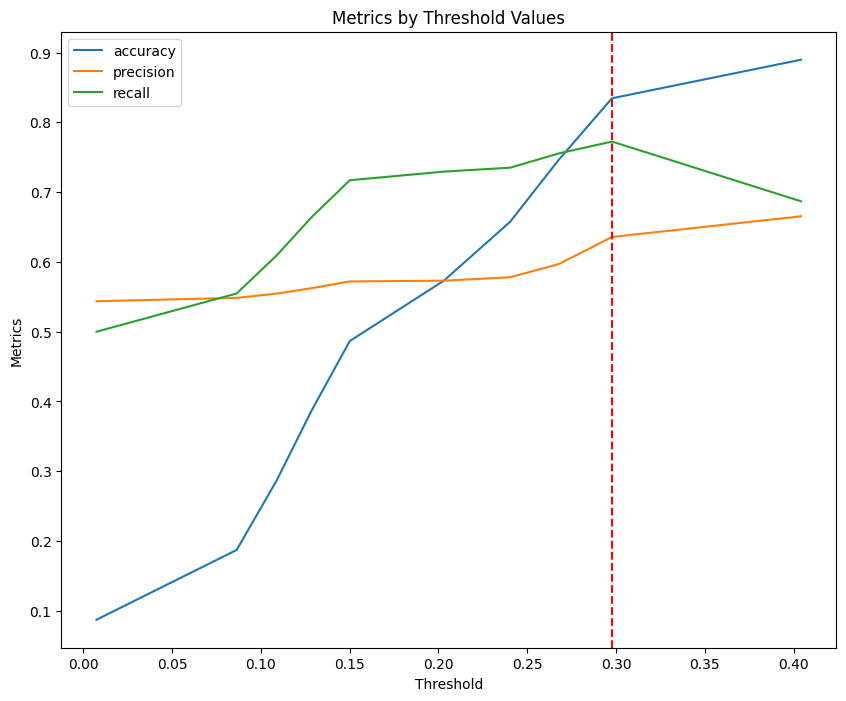

In [ ]:
# Plot accuracy, precision and recall with highlighting max recall value
plt.figure(figsize=(10,8))
plt.plot(thresh_df['threshold'], thresh_df['accuracy'], label='accuracy')
plt.plot(thresh_df['threshold'], thresh_df['precision'], label='precision')
plt.plot(thresh_df['threshold'], thresh_df['recall'], label='recall')
plt.axvline(x=threshold, color='r', linestyle='dashed')
plt.xlabel('Threshold')
plt.ylabel('Metrics')
plt.title('Metrics by Threshold Values')
plt.legend()
plt.show()

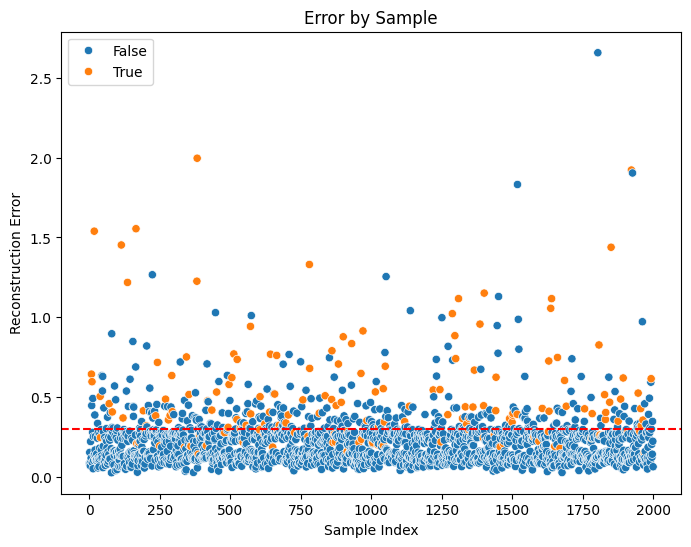

In [ ]:
# Visually validate the selected threshold.
temp = recons_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.scatterplot(data=temp, x=temp.index, y='error', hue='y_true')
plt.axhline(y=threshold, color='r', linestyle='dashed')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Error by Sample')
plt.legend()
plt.show()

In [ ]:
# Classify error value
recons_df['y_pred'] = recons_df['error'] > threshold
recons_df.head()

,error,y_true,y_pred
0,0.115469,False,False
1,0.060585,False,False
2,0.302406,True,True
3,0.105787,False,False
4,0.291239,False,False


In [26]:
print(classification_report(recons_df['y_true'],recons_df['y_pred']))

              precision    recall  f1-score   support

       False       0.97      0.85      0.90    182538
        True       0.30      0.70      0.42     17462

    accuracy                           0.83    200000
   macro avg       0.64      0.77      0.66    200000
weighted avg       0.91      0.83      0.86    200000



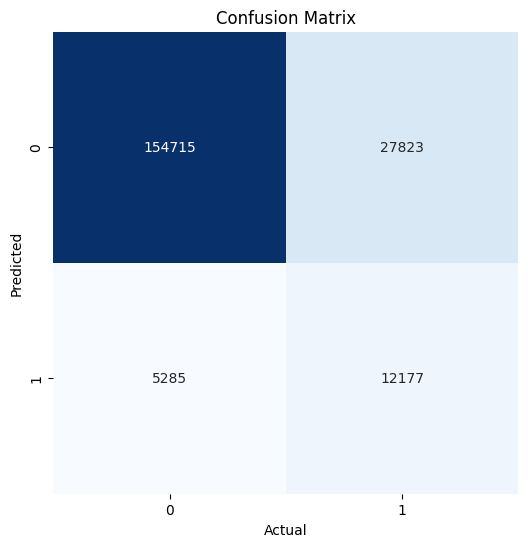

In [27]:
cm = confusion_matrix(recons_df['y_true'],recons_df['y_pred'])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, fmt='.6g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [28]:
print(f"Recall Score: {recall_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")
print(f"Accuracy Score: {accuracy_score(recons_df['y_true'],recons_df['y_pred'])*100:.3f}%")

Recall Score: 69.734%
Accuracy Score: 83.446%
